## Details

The notebook contains the synthetic data experiment with low noise (sigma^2 = 0.05). Due to the non-convexity of the HNCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import sys
import itertools
from utils import *

sys.path.append("./src")
import torch
import numpy as np
from matplotlib import pyplot as plt

from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor, Recon_Loss, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm
from lsqnonneg_module import LsqNonneg
from trainNNCPD import train
#
import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

from sklearn.decomposition import NMF

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

## Generate Data Tensor

In [2]:
## set the network parameters
torch.set_default_tensor_type(torch.DoubleTensor)

X = get_synthetic_tensor()

In [20]:
X_original = get_synthetic_tensor(noise=0)

### Visualize Original Data Tensor

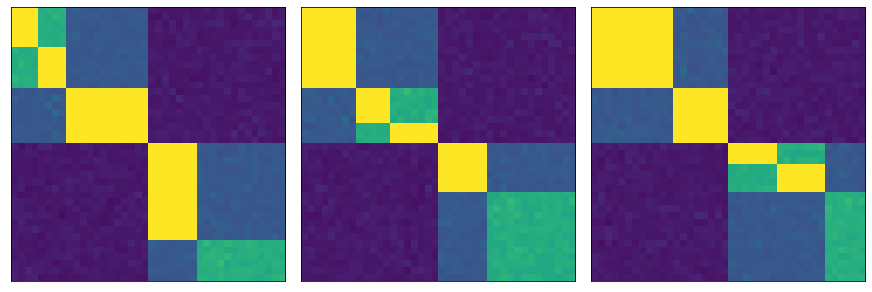

In [3]:
display_tensor(X)

In [4]:
X = torch.from_numpy(X)
X_np = np.asarray(X)

## Run Neural NCPD

In [5]:
# unsupervised case,one layer
r=7
n1,n2,n3 = X.shape

num_trials = 10
histories = []

for i in range(num_trials):
    
    torch.manual_seed(i)

    net = NNCPD([n1, 4, 2],[n2, 4, 2],[n3, 4, 2])
    loss_func = Energy_Loss_Tensor()
    h = train(net, X, loss_func, r, epoch = 7500, lr1 = 0, lr2 = 50)
    histories.append(h)


/home/jvendrow/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


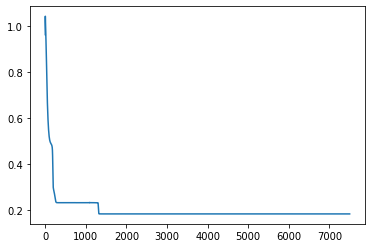

In [6]:
# plot the loss curve
histories[0].plot_scalar('loss')

In [7]:
S_trues = get_synthetic_gt_topics()

In [8]:
all_topic_losses, all_recon_losses = measure_all(histories, X_np, S_trues, kind="Neural")

handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.04310424175371318 0.002637882416244456 0.2153776277997652
Topic Modeling Loss 7 to 4 (average, best, worst): 0.04211838800164144 0.0023534462714323973 0.205795638325977
Topic Modeling Loss 4 to 2 (average, best, worst): 0.04223941408098822 0.005845247203841973 0.2502222760931831

Relative Recon Loss Rank 7 (average, best, worst): 0.09631970490841361 0.09631970490840853 0.09631970490841732
Relative Recon Loss Rank 4 (average, best, worst): 0.2306551768042581 0.2171728210713715 0.3519589280455683
Relative Recon Loss Rank 2 (average, best, worst): 0.53034785052147 0.5303409676047632 0.5303601632486924


In [21]:
all_topic_losses, all_recon_losses = measure_all(histories, X_original, S_trues, kind="Neural")

handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.04310424175371318 0.002637882416244456 0.2153776277997652
Topic Modeling Loss 7 to 4 (average, best, worst): 0.04211838800164144 0.0023534462714323973 0.205795638325977
Topic Modeling Loss 4 to 2 (average, best, worst): 0.04223941408098822 0.005845247203841973 0.2502222760931831

Relative Recon Loss Rank 7 (average, best, worst): 0.1187897713361051 0.11878977133610057 0.11878977133610837
Relative Recon Loss Rank 4 (average, best, worst): 0.2524510019193263 0.2385528113335064 0.3771243698510093
Relative Recon Loss Rank 2 (average, best, worst): 0.5628380756843907 0.562687334654858 0.5632015113766597


In [9]:
def standard_HNCPD(X, ranks, seed=0):
    
    np.random.seed(2)
    factors_tl = non_negative_parafac(X, ranks[0])
    
    X_1 =  factors_tl[0]
    X_2 =  factors_tl[1]
    X_3 =  factors_tl[2]
    
    factors = [[X_1], [X_2], [X_3]]
    
    for i in range(1, len(ranks)):
        r = ranks[i]
        for j in range(3):
            model = NMF(n_components=r, init='random', random_state=seed, max_iter=300, solver='mu')
            A = model.fit_transform(factors[j][2*i-2])
            S = model.components_

            factors[j].append(A)
            factors[j].append(S)
            
    return factors

In [10]:
num_trials = 10
all_factors = []
for i in range(num_trials):
    factors = standard_HNCPD(X_np, [7,4,2], seed=i)
    all_factors.append(factors)

In [11]:
all_topic_losses, all_recon_losses = measure_all(all_factors, X_np, S_trues, kind="Standard")

handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.10575072361742997 0.009766357175004165 0.2843265404695422
Topic Modeling Loss 7 to 4 (average, best, worst): 0.10093002773034329 0.008824998649549803 0.1987577306994643
Topic Modeling Loss 4 to 2 (average, best, worst): 0.18925579316578658 0.014433730333846068 0.28436942439735485

Relative Recon Loss Rank 7 (average, best, worst): 0.09631970490841418 0.09631970490840637 0.09631970490841901
Relative Recon Loss Rank 4 (average, best, worst): 0.4682536676182603 0.46647599733882583 0.469993477149036
Relative Recon Loss Rank 2 (average, best, worst): 0.8152656799281802 0.6491065026309738 0.9154293006189043


In [24]:
all_topic_losses, all_recon_losses = measure_all(all_factors, X_original, S_trues, kind="Standard")

handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.10575072361742997 0.009766357175004165 0.2843265404695422
Topic Modeling Loss 7 to 4 (average, best, worst): 0.10093002773034329 0.008824998649549803 0.1987577306994643
Topic Modeling Loss 4 to 2 (average, best, worst): 0.18925579316578658 0.014433730333846068 0.28436942439735485

Relative Recon Loss Rank 7 (average, best, worst): 0.11878977133610555 0.11878977133609872 0.11878977133610986
Relative Recon Loss Rank 4 (average, best, worst): 0.49406419039224597 0.4901545516898462 0.4968988292025292
Relative Recon Loss Rank 2 (average, best, worst): 0.8277137602349078 0.6833347463432453 0.9178393156775861


## Visualization

In [12]:
X1 = np.asarray(histories[0].get('A_X1')[-1])
X2 = np.asarray(histories[0].get('B_X1')[-1])
X3 = np.asarray(histories[0].get('C_X1')[-1])


A_A1 = np.asarray(histories[0].get('A_A1')[-1])
A_S1 = np.asarray(histories[0].get('A_S1')[-1])
B_A1 = np.asarray(histories[0].get('B_A1')[-1])
B_S1 = np.asarray(histories[0].get('B_S1')[-1])
C_A1 = np.asarray(histories[0].get('C_A1')[-1])
C_S1 = np.asarray(histories[0].get('C_S1')[-1])

A_A2 = np.asarray(histories[0].get('A_A2')[-1])
A_S2 = np.asarray(histories[0].get('A_S2')[-1])
B_A2 = np.asarray(histories[0].get('B_A2')[-1])
B_S2 = np.asarray(histories[0].get('B_S2')[-1])
C_A2 = np.asarray(histories[0].get('C_A2')[-1])
C_S2 = np.asarray(histories[0].get('C_S2')[-1])


### All models, Rank 7

Relative reconstruction loss: 0.0963197049084112


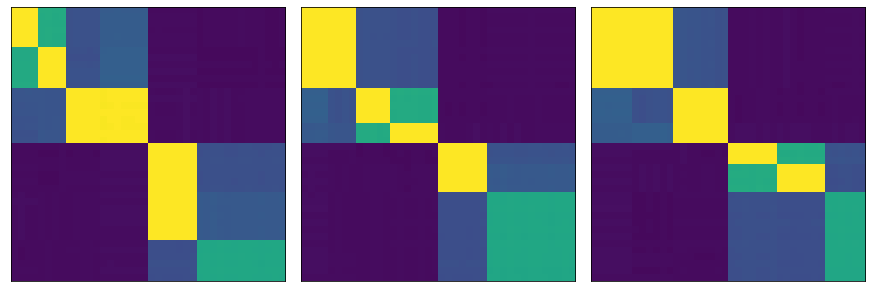

In [13]:
approx = outer_product_np(X1, X2, X3)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
display_tensor(approx)

### Neural NCPD, Rank 4

Relative reconstruction loss: 0.21717879697975728


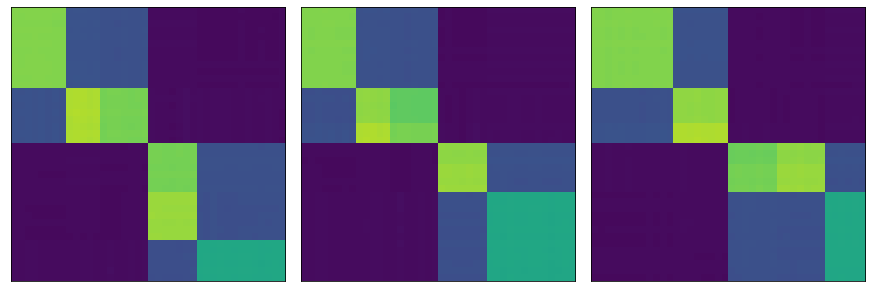

In [14]:
approx = outer_product_np(A_A1 @ A_S1, B_A1 @ B_S1, C_A1 @ C_S1)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
display_tensor(approx)

### Neural NCPD, Rank 2

Relative reconstruction loss: 0.5303409676047632


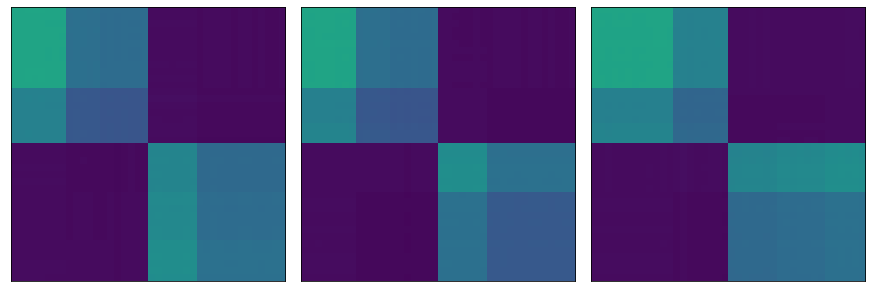

In [15]:
approx = outer_product_np(A_A1 @ A_A2 @ A_S2, B_A1 @ B_A2 @ B_S2, C_A1 @ C_A2 @ C_S2)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
display_tensor(approx)

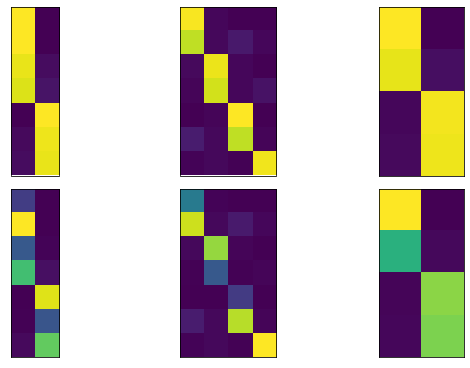

In [16]:
display_topic_matrices([A_S2.T, A_S1.T, A_A2], S_trues)

### Standard HNCPD, Rank 4

Relative reconstruction loss: 0.4668036527196204


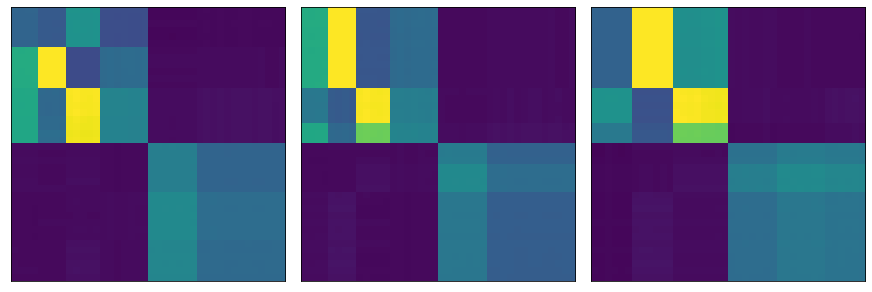

In [17]:
X1, A_A1, A_S1, A_A2, A_S2 = all_factors[0][0]
X2, B_A1, B_S1, B_A2, B_S2 = all_factors[0][1]
X3, C_A1, C_S1, C_A2, C_S2 = all_factors[0][2]

approx = outer_product_np(A_A1 @ A_S1, B_A1 @ B_S1, C_A1 @ C_S1)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
display_tensor(approx)

### Standard HNCPD, Rank 2

Relative reconstruction loss: 0.8020052038717367


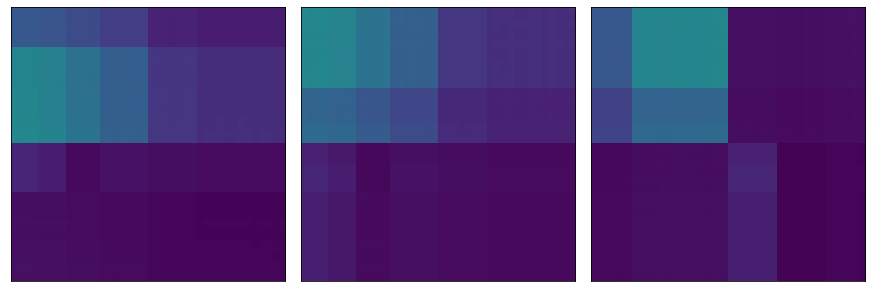

In [18]:
approx = outer_product_np(A_A1 @ A_A2 @ A_S2, B_A1 @ B_A2 @ B_S2, C_A1 @ C_A2 @ C_S2)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
display_tensor(approx)

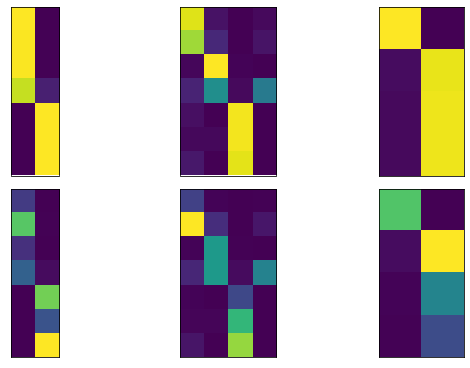

In [19]:
display_topic_matrices([A_S2.T, A_S1.T, A_A2], S_trues)

### Dislay S_true matrices

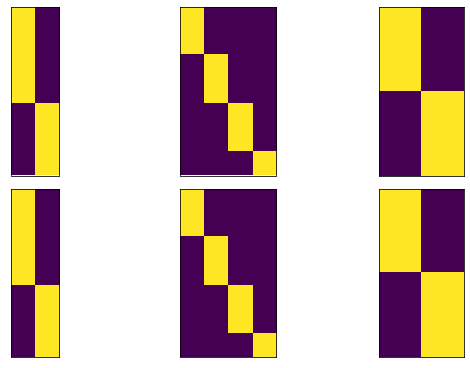

In [25]:
display_topic_matrices(S_trues, S_trues)